In [16]:
%matplotlib inline
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

# Self-diffusion & Conductivity (MSD)

In [217]:
# select what to plot
rho = 1.0753  # 1.1551 # 1.0753
r = f"{rho:.2f}"
T = 340
geos = ["a32b32i0", "a16b16i16", "a0b0i32"]


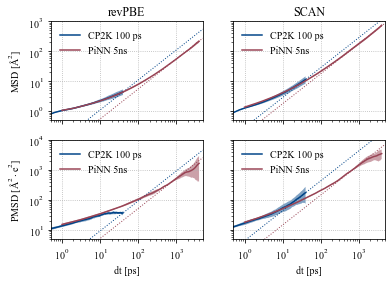

In [230]:
f, axs = plt.subplots(2, 2, figsize=[6, 4], sharex=True, sharey='row')

xlim = [0.5, 5000.0]
ylim0 = [0.5, 1000]
ylim1 = [5, 10000]

def plot_msd(ax, data, which=1, unit=1, sharex=True,**kwargs):
    maxt = 1000
    maxs = np.sum(data[0][:, 0]<maxt)-1
    # data = [d[:maxs] for d in data]
    t = data[0][:, 0]
    msd_mean = np.mean([dat[:, which] for dat in data], axis=0)
    msd_std = np.std([dat[:, which] for dat in data], axis=0)
    (l,) = ax.plot(t, msd_mean, **kwargs)
    ax.plot(xlim, np.array(xlim) / t[maxs] * msd_mean[maxs], lw=1, ls=":", **kwargs)
    kwargs["facecolor"] = kwargs.pop("color")
    ax.fill_between(t, msd_mean - msd_std, msd_mean + msd_std, alpha=0.5, **kwargs)
    return l


for tag, ax in zip(["hicut", "scan"], axs.T):
    exp = f"../exp/{tag}"
    cp2k = f"nvt-{tag}"
    ana = f"{exp}/analyses"

    data_cp2k = [
        np.load(f"{ana}/cp2k/{cp2k}/{geo}-rho{rho}/msd-10-110ps/msd.npy")
        for geo in geos
    ]
    data_prod = [
        np.load(f"{exp}/analyses/prod/nvt-{T}k-5ns-0/{geo}-r{r}/msd-0-5ns/msd.npy")
        for geo in geos
    ]
    pdata_cp2k = [
        np.load(f"{ana}/cp2k/{cp2k}/{geo}-rho{rho}/msd-10-110ps/pmsd.npy")
        for geo in geos
    ]
    pdata_prod = [
        np.load(f"{exp}/analyses/prod/nvt-{T}k-5ns-0/{geo}-r{r}/msd-0-5ns/pmsd.npy")
        for geo in geos
    ]
    
    
    l1 = plot_msd(ax[0], data_cp2k, color="C0")
    l2 = plot_msd(ax[0], data_prod, color="C1")
    
    l1 = plot_msd(ax[1], pdata_cp2k, color="C0")
    l2 = plot_msd(ax[1], pdata_prod, color="C1")

    for a in ax:
        a.set_xscale("log")
        a.set_yscale("log")
        a.set_xlim(*xlim)
        
        a.legend([l1, l2], ["CP2K 100 ps", "PiNN 5ns"], loc=2)
        a.grid()
    ax[0].set_ylim(*ylim0)
    ax[1].set_yticks([10**i for i in range(1,5)])
    ax[1].set_yticks([j*10**i for i in range(0,4) for j in range(2,10)], minor=True)
    ax[1].set_ylim(*ylim1)
    ax[1].set_xlabel("dt [ps]")


axs[0,0].set_title('revPBE')
axs[0,1].set_title('SCAN')
axs[0,0].set_ylabel("MSD [$\AA^2$]")
axs[1,0].set_ylabel("PMSD [$\AA^2\cdot{}e^2$]")

f.savefig('msd_pmsd_340K.pdf')

Text(0, 0.5, 'g(r)')

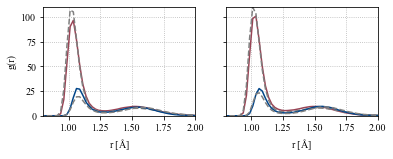

In [211]:
f, axs = plt.subplots(1, 2, figsize=[6, 2], sharey=True)


def plot_rdf(ax, data, which=1, **kwargs):
    rmid = data[0][:, 0]
    rdf_mean = np.mean([dat[:, 1] for dat in data], axis=0)
    rdf_std = np.std([dat[:, 1] for dat in data], axis=0)
    (l,) = ax.plot(rmid, rdf_mean, **kwargs)
    return l


for tag, ax in zip(["hicut", "scan"], axs):
    exp = f"../exp/{tag}"
    cp2k = f"nvt-{tag}"
    ana = f"{exp}/analyses"
    ho_cp2k = [
        np.loadtxt(f"{ana}/cp2k/{cp2k}/{geo}-rho{rho}/rdf-10-110ps/HO_rdf.dat")
        for geo in geos
    ]
    ho_prod = [
        np.loadtxt(f"{ana}/prod/nvt-{T}k-5ns-0/{geo}-r{r}/rdf-0-5ns/HO_rdf.dat")
        for geo in geos
    ]
    hn_cp2k = [
        np.loadtxt(f"{ana}/cp2k/{cp2k}/{geo}-rho{rho}/rdf-10-110ps/HN_rdf.dat")
        for geo in geos
    ]
    hn_prod = [
        np.loadtxt(f"{ana}/prod/nvt-{T}k-5ns-0/{geo}-r{r}/rdf-0-5ns/HN_rdf.dat")
        for geo in geos
    ]

    plot_rdf(ax, ho_prod, which=which, color="C1")
    plot_rdf(ax, ho_cp2k, which=which, color="gray", ls="--")
    plot_rdf(ax, hn_prod, which=which, color="C0")
    plot_rdf(ax, hn_cp2k, which=which, color="gray", ls="--")
    ax.set_xlim(0.8, 2)
    ax.set_ylim(0, 110)
    ax.grid()
    ax.set_xlabel("r [$\AA$]")
axs[0].set_ylabel("g(r)")

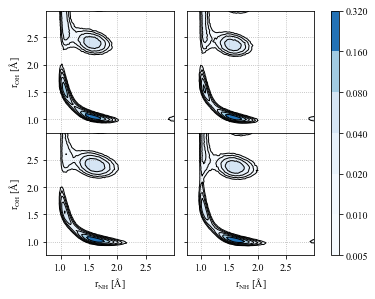

In [212]:
f, axs = plt.subplots(
    2,
    2,
    figsize=[6, 4.5],
    sharex=True,
    sharey=True,
    gridspec_kw={"hspace": 0, "wspace": 0.1},
)


def plot_2drdf(ax, data, which=1, **kwargs):
    r = np.arange(0, 5, 0.025)
    l = ax.contour(
        r,
        r,
        np.mean(data, axis=0).T,
        levels=[0.005 * 2**i for i in range(7)],
        linewidths=1,
        **kwargs,
    )
    c = ax.contourf(
        r,
        r,
        np.mean(data, axis=0).T,
        levels=[0.005 * 2**i for i in range(7)],
        cmap="Blues",
        vmax=0.005 * 2**6,
    )
    return l, c


for tag, ax in zip(["hicut", "scan"], axs.T):
    exp = f"../exp/{tag}"
    cp2k = f"nvt-{tag}"
    ana = f"{exp}/analyses"
    ax1, ax2 = ax
    nho_cp2k = [
        np.loadtxt(f"{ana}/cp2k/{cp2k}/{geo}-rho{rho}/rdf-10-110ps/NHO_rdf.dat")
        for geo in geos
    ]
    nho_prod = [
        np.loadtxt(f"{ana}/prod/nvt-{T}k-5ns-0/{geo}-r{r}/rdf-0-5ns/NHO_rdf.dat")
        for geo in geos
    ]
    l1, c1 = plot_2drdf(ax1, nho_prod, colors="k")
    l2, c2 = plot_2drdf(ax2, nho_cp2k, colors="k")

    for ax in [ax1, ax2]:
        ax.set_xlim(0.75, 2.99)
        ax.set_ylim(0.75, 2.99)
        ax.set_xticks(np.arange(1.0, 3.0, 0.5))
        ax.grid()

for ax in axs[-1, :]:
    ax.set_xlabel("$r_{NH}$ [$\AA$]")
for ax in axs[:, 0]:
    ax.set_ylabel("$r_{OH}$ [$\AA$]")
f.colorbar(c1, ax=axs.ravel().tolist(), aspect=30)

17727.0 4705.0 9228.666666666666
1222800.6666666667 367631.3333333333 614191.6666666666


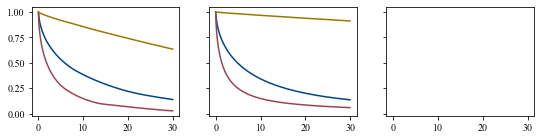

In [215]:
def fit(t, prob):
    def f(x, A, t1, t2): 
        return A*np.exp(-x/t1)+(1-A)*np.exp(-x/t2)
    (A, t1, t2), _ = curve_fit(f, t, prob, maxfev=5000)
    return A*t1+(1-A)*t2

f, axs = plt.subplots(1, 3, figsize=[9, 2], sharex=True, sharey=True)

pre_scan = '../exp/scan/analyses/cp2k/a*-rho1.0753'
pre_scan_acle = '../exp/scan/analyses/prod/nvt-300k-5ns-0/a*-r1.08/'

for pre, ax in zip([pre_scan, pre_scan_acle], axs):
    files = glob(f"{pre}/persist.dat")
    t, a, b, p = np.mean([np.loadtxt(f) for f in files], axis=0).T
    print(a[0],b[0],p[0])
    ax.plot(t, a/a[0])
    ax.plot(t, b/b[0])
    ax.plot(t, p/p[0])

[(50000, 11), (50000, 11), (50000, 11)]
[(50000, 11), (50000, 11), (50000, 11)]
[(50000, 11), (50000, 11), (50000, 11)]


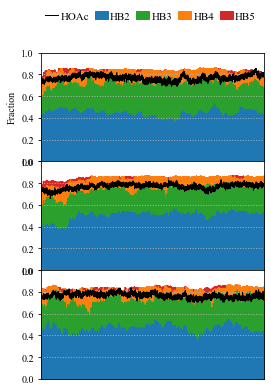

In [239]:
def draw_hb_net(ax, files, window=10):
    hbnet =  [np.loadtxt(data) for data in files]
    print([np.loadtxt(data).shape for data in files])
    hbnet = np.array(hbnet)
    t = hbnet[0,::window,0]
    molperc = hbnet[:,:,1].reshape([hbnet.shape[0],-1,window])/32.
    molperc = molperc.mean(axis=2)
    hbpop = hbnet[:,:,3:].cumsum(axis=2)/64.
    hbpop = hbpop.reshape([hbpop.shape[0],-1,window,hbpop.shape[-1]]).mean(axis=2)
    # axis: sample, time, HBSIZE
    colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
    l, = ax.plot(t, molperc.mean(axis=0), 'k-', lw=1)
    handles = []
    for x, color in list(zip(hbpop.T, colors))[::-1]:
        h = ax.fill_between(t, x.mean(axis=1), color=color, alpha=1)
        handles.append(h)
    handles.append(l)
    return handles

f, axs = plt.subplots(3,1,gridspec_kw={'hspace':0},
                      figsize=[4,6], sharey=True)
[ax.grid(lw=1) for ax in axs]

files =  glob('../exp/hicut/analyses/prod/nvt-340k-5ns-0/*r1.08/hbnet.dat')
handles = draw_hb_net(axs[0], files, window=10)
files =  glob('../exp/scan/analyses/prod/nvt-300k-5ns-0/*r1.08/hbnet.dat')
handles = draw_hb_net(axs[1], files, window=10)
files =  glob('../exp/scan/analyses/prod/nvt-340k-5ns-0/*r1.08/hbnet.dat')
handles = draw_hb_net(axs[2], files, window=10)

axs[0].legend(handles[::-1], 
              ['HOAc']+[f'HB{i+2}' for i in range(len(handles))], 
              loc=3, bbox_to_anchor=[0,1.25],
              handlelength=1.2, ncol=5, fontsize=11,
              columnspacing=0.5, handletextpad=0.2, 
              borderaxespad=0)

[ax.set_xticks([]) for ax in axs]
axs[0].set_xlim(0,5000)
axs[1].set_xlim(0,5000)
axs[2].set_xlim(0,5000)
axs[0].set_ylim(0,1)

axs[0].set_ylabel('Fraction')
plt.savefig('hbnet.pdf')